In [3]:
import os, csv
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import concurrent.futures
import uproot
import uproot._connect._pandas

from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle

from mpl_toolkits.mplot3d import Axes3D # for 3D plotting
mpl.rcParams['image.cmap'] = 'hot_r' # change default color map

# %matplotlib inline

In [4]:
directory_path = "/eos/cms/store/group/dpg_hgcal/tb_hgcal/2018/cern_h2_october\
/offline_analysis/sim_ntuples/v2/withMCP/"

In [5]:
e_file = directory_path + "ntuple_sim_config22_pdgID11_beamMomentum200_listFTFP_BERT_EMM.root"

In [6]:
p_file = directory_path + "ntuple_sim_config22_pdgID211_beamMomentum200_listFTFP_BERT_EMM.root"

#### Loading electrons data

In [7]:
file_content = uproot.open(e_file)

In [8]:
hits = file_content["rechitntupler/hits"]

In [9]:
hits.keys()

[b'event',
 b'trigger_timestamp',
 b'run',
 b'pdgID',
 b'beamEnergy',
 b'trueBeamEnergy',
 b'energyLostEE',
 b'energyLostFH',
 b'energyLostBH',
 b'energyLostBeam',
 b'energyLostOutside',
 b'NRechits',
 b'rechit_detid',
 b'rechit_module',
 b'rechit_layer',
 b'rechit_chip',
 b'rechit_channel',
 b'rechit_type',
 b'rechit_x',
 b'rechit_y',
 b'rechit_z',
 b'rechit_iu',
 b'rechit_iv',
 b'rechit_iU',
 b'rechit_iV',
 b'rechit_energy',
 b'rechit_energy_noHG',
 b'rechit_amplitudeHigh',
 b'rechit_amplitudeLow',
 b'rechit_hg_goodFit',
 b'rechit_lg_goodFit',
 b'rechit_hg_saturated',
 b'rechit_lg_saturated',
 b'rechit_fully_calibrated',
 b'rechit_noise_flag',
 b'rechit_TS2High',
 b'rechit_TS2Low',
 b'rechit_TS3High',
 b'rechit_TS3Low',
 b'rechit_Tot',
 b'rechit_toa_calib_flag',
 b'rechit_toaFall_flag',
 b'rechit_toaRise_flag',
 b'rechit_toaFall_norm',
 b'rechit_toaRise_norm',
 b'rechit_toaFall_time',
 b'rechit_toaRise_time',
 b'rechit_toaFall_corr_time',
 b'rechit_toaRise_corr_time',
 b'rechit_calib

###### For showere profiles taking x,y,z,corresponding layer and energy

In [10]:
columns = ['rechit_layer','rechit_x','rechit_y','rechit_z','rechit_energy']
# no need to take events id, event ids are insignificant for computation.

In [11]:
no_of_events = 20000 # taking initial 2000 events (sample)

In [12]:
%%time
cache = {}
executor = concurrent.futures.ThreadPoolExecutor(32) # 32 threads
df_elon = hits.pandas.df(columns,
                           entrystop = no_of_events, flatten = True,executor = executor)

CPU times: user 5.25 s, sys: 1.86 s, total: 7.1 s
Wall time: 3.68 s


In [13]:
print(df_elon.__len__()/1000000,'million rows') # no of samples

17.989141 million rows


#### Loading pions data

In [14]:
file_content = uproot.open(p_file)

In [15]:
hits = file_content["rechitntupler/hits"]

In [16]:
%%time
cache = {}
executor = concurrent.futures.ThreadPoolExecutor(16) # 32 threads
df_pion = hits.pandas.df(columns, cache = cache,
                           entrystop = no_of_events, flatten = True,executor = executor)

CPU times: user 4.67 s, sys: 1.31 s, total: 5.98 s
Wall time: 3.1 s


#### Beam Energy = 200 GeV
#### pdgIDs
     11 = e-
    211 = pi+

In [17]:
df_elon = df_elon.dropna()
df_pion = df_pion.dropna()

df_elon.head()

rechit_layer  rechit_x  rechit_y  rechit_z  rechit_energy
entry subentry                                                           
0     0                    1 -2.915291  2.805240   13.8775       6.624156
      1                    1 -2.915291  1.683144   13.8775      32.874466
      2                    1 -2.915291 -0.561048   13.8775       2.074640
      3                    2  0.000000 -3.366288   14.7675       0.552938
      4                    2 -0.971764  1.683144   14.7675       8.784291

replace index with entry of event and name it as event.

In [18]:
df_elon = df_elon.reset_index(level=1,drop=True)
df_elon.index.names = ['event']

df_pion = df_pion.reset_index(level=1,drop=True)
df_pion.index.names = ['event']

Some of the enetries are missing from pion/electron run, remove extra entries from data.

In [19]:
# if df_pion.index.max() > df_elon.index.max():
#     df_pion = df_pion[df_pion.index <= df_elon.index.max()]
# elif df_pion.index.max() < df_elon.index.max():
#     df_elon = df_elon[df_elon.index <= df_pion.index.max()]

### An event

In [20]:
event_id = 1

elon_event = df_elon[df_elon.index == event_id] # electron
pion_event = df_pion[df_pion.index == event_id] # pion

ex = elon_event.rechit_x.values
ey = elon_event.rechit_y.values
ez = elon_event.rechit_z.values
es = elon_event.rechit_energy.values

px = pion_event.rechit_x.values
py = pion_event.rechit_y.values
pz = pion_event.rechit_z.values
ps = pion_event.rechit_energy.values

#### Layers setup

Text(0.5,0,'z-axis ( layers location )')

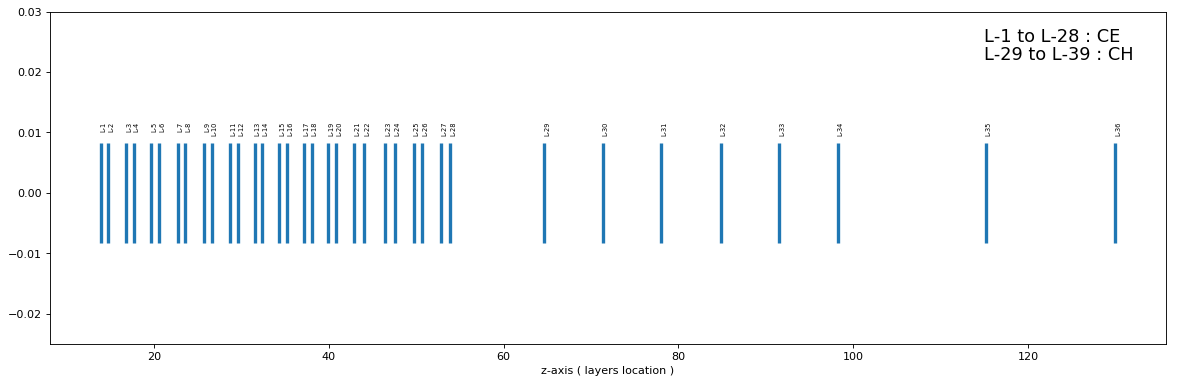

In [21]:
plt.figure(num=None, figsize=(18,5.5), dpi=80)

layers_loc = pion_event.groupby("rechit_layer")["rechit_z"].mean().values # all values of Z are same for a layer
layers = len(layers_loc) # no of layers
fcd = np.zeros(layers)

plt.plot(layers_loc,fcd,'|',markersize='90',mew=3)
plt.ylim(-0.025,0.03)

for i in range(0,layers):
    plt.text(layers_loc[i], .011, "L-"+str(i+1),rotation='vertical',size=6)

plt.text(115, .025, "L-1 to L-28 : CE",size=16)
plt.text(115, .022, "L-29 to L-39 : CH",size=16)
plt.xlabel("z-axis ( layers location )")

#### Longitudinal shower

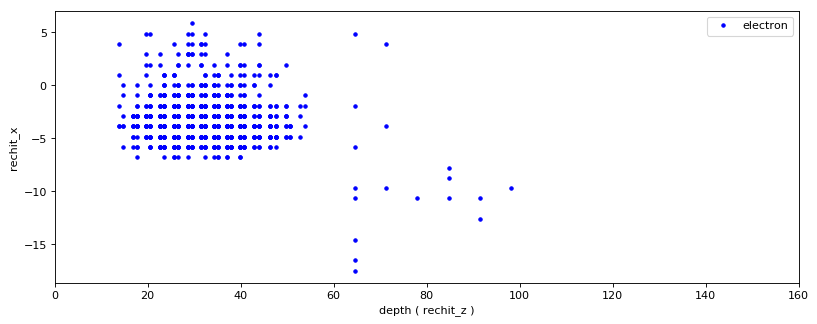

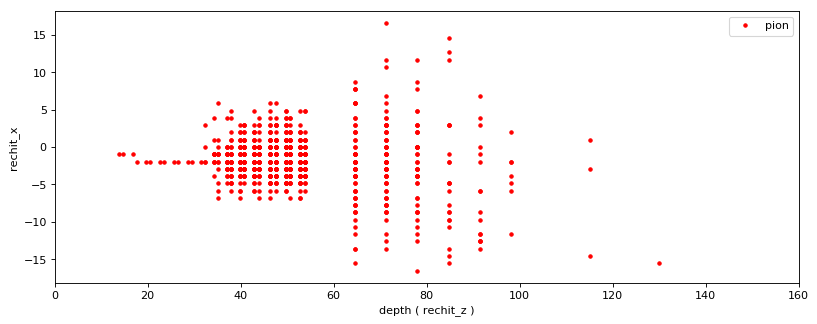

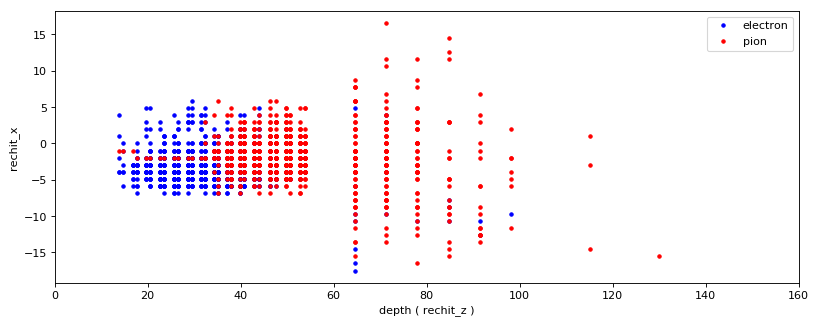

In [22]:
# electron
plt.figure(num=None, figsize=(12,4.5), dpi=80)
plt.plot(ez,ex,'.',color='b')
plt.xlim(0,160)
plt.xlabel("depth ( rechit_z )")
plt.ylabel("rechit_x")
plt.legend(["electron"])
# pion
plt.figure(num=None, figsize=(12,4.5), dpi=80)
plt.plot(pz,px,'.',color='r')
plt.xlim(0,160)
plt.xlabel("depth ( rechit_z )")
plt.ylabel("rechit_x")
plt.legend(["pion"])
# both
plt.figure(num=None, figsize=(12,4.5), dpi=80)
plt.plot(ez,ex,'.',color='b')
plt.plot(pz,px,'.',color='r')
plt.xlim(0,160)
plt.xlabel("depth ( rechit_z )")
plt.ylabel("rechit_x")

temp = plt.legend(["electron","pion"])

#### rechit energy > 0.50 ( intrinsic noise )

In [23]:
df_elon = df_elon[df_elon.rechit_energy > 0.50]
df_pion = df_pion[df_pion.rechit_energy > 0.50]

ex = elon_event.rechit_x.values
ey = elon_event.rechit_y.values
ez = elon_event.rechit_z.values
es = elon_event.rechit_energy.values

px = pion_event.rechit_x.values
py = pion_event.rechit_y.values
pz = pion_event.rechit_z.values
ps = pion_event.rechit_energy.values

Text(0,0.5,'rechit_x')

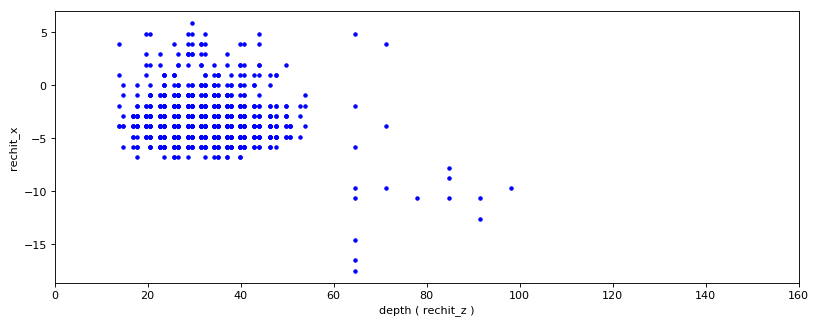

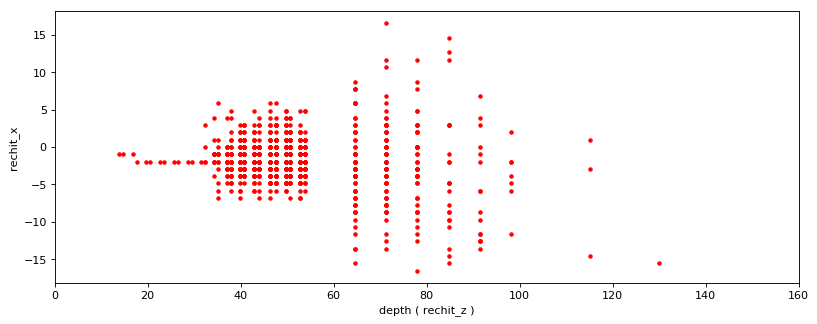

In [24]:
# electron
plt.figure(num=None, figsize=(12,4.5), dpi=80)
plt.plot(ez,ex,'.',color='b')
plt.xlim(0,160)
plt.xlabel("depth ( rechit_z )")
plt.ylabel("rechit_x")

# pion
plt.figure(num=None, figsize=(12,4.5), dpi=80)
plt.plot(pz,px,'.',color='r')
plt.xlim(0,160)
plt.xlabel("depth ( rechit_z )")
plt.ylabel("rechit_x")


### Transverse shower

#### Energy deposit at location (x,y,z)

Size of a point proportional to rechit_energy at that poin 

Text(0.5,0.92,'Energy deposit (pion)')

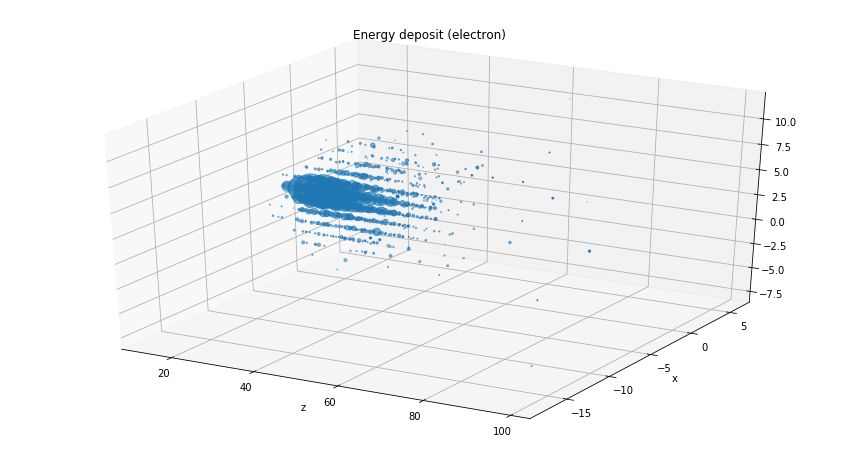

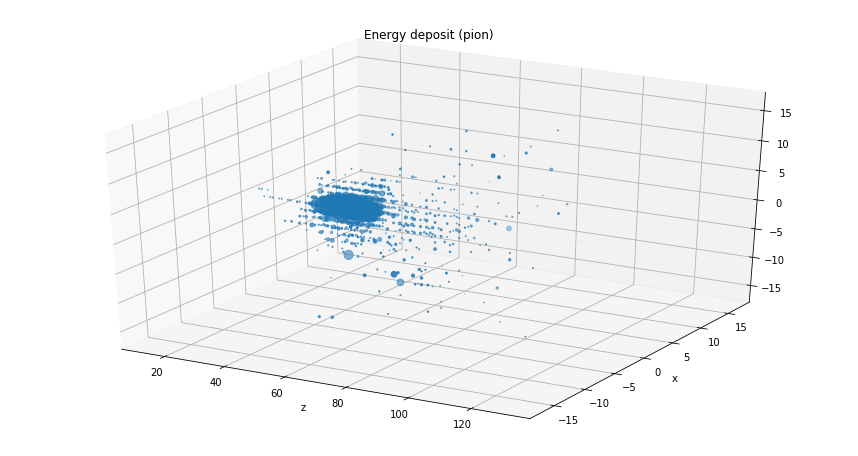

In [25]:
elon_fig = plt.figure(figsize = (15,8))
ax = elon_fig.add_subplot(111, projection='3d')

_temp = ax.scatter(ez,ex,ey,s = es)
plt.xlabel("z")
plt.ylabel("x")
ax.set_title("Energy deposit (electron)")

pion_fig = plt.figure(figsize = (15,8))
ay = pion_fig.add_subplot(111, projection='3d')

_temp = ay.scatter(pz,px,py,s = ps)
plt.xlabel("z")
plt.ylabel("x")
ay.set_title("Energy deposit (pion)")

Size of a point proportional to rechit_energy and color represent a layer.
white => 1st layer

<IPython.core.display.Javascript object>


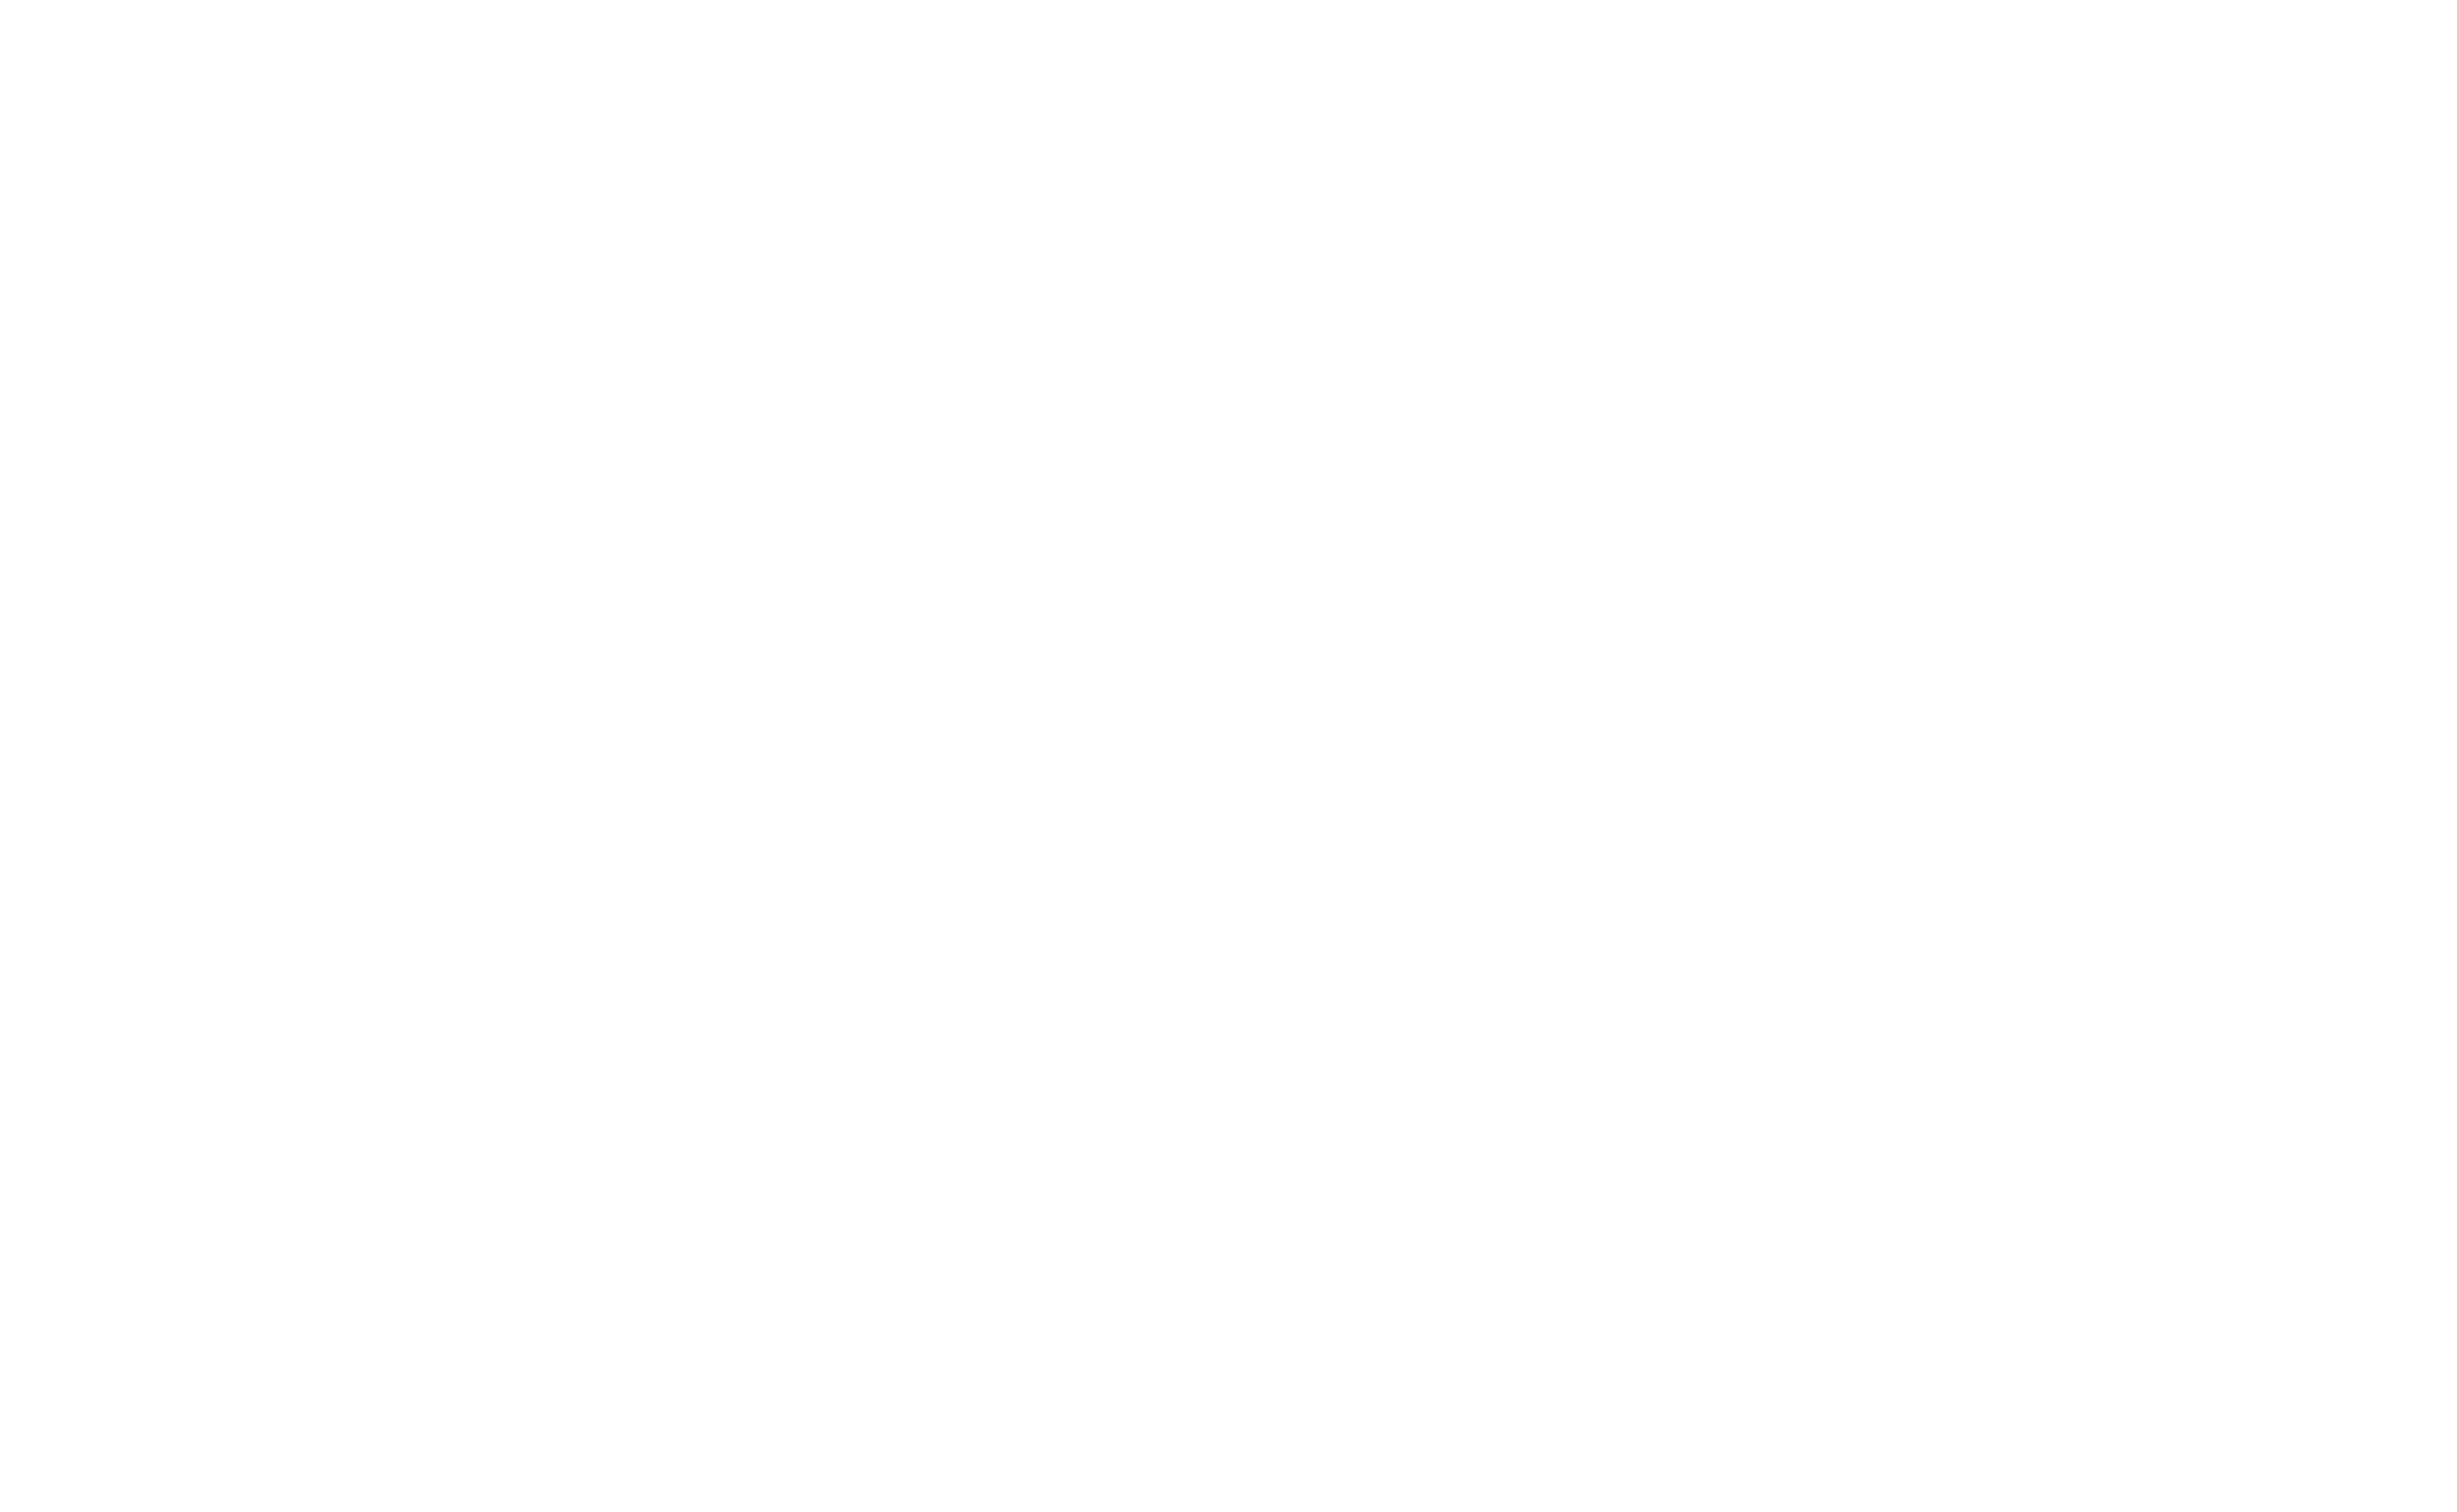

Text(0.5,0.92,'Energy deposit (electron)')

In [26]:
# layers
%matplotlib notebook
elon_fig = plt.figure(figsize = (13,8))
ax = elon_fig.add_subplot(111, projection='3d')

ec = elon_event.rechit_layer.values 

ax.scatter(ez,ex,ey, s = es,c = ec)
plt.xlabel("z")
plt.ylabel("x")
ax.set_title("Energy deposit (electron)")

<IPython.core.display.Javascript object>


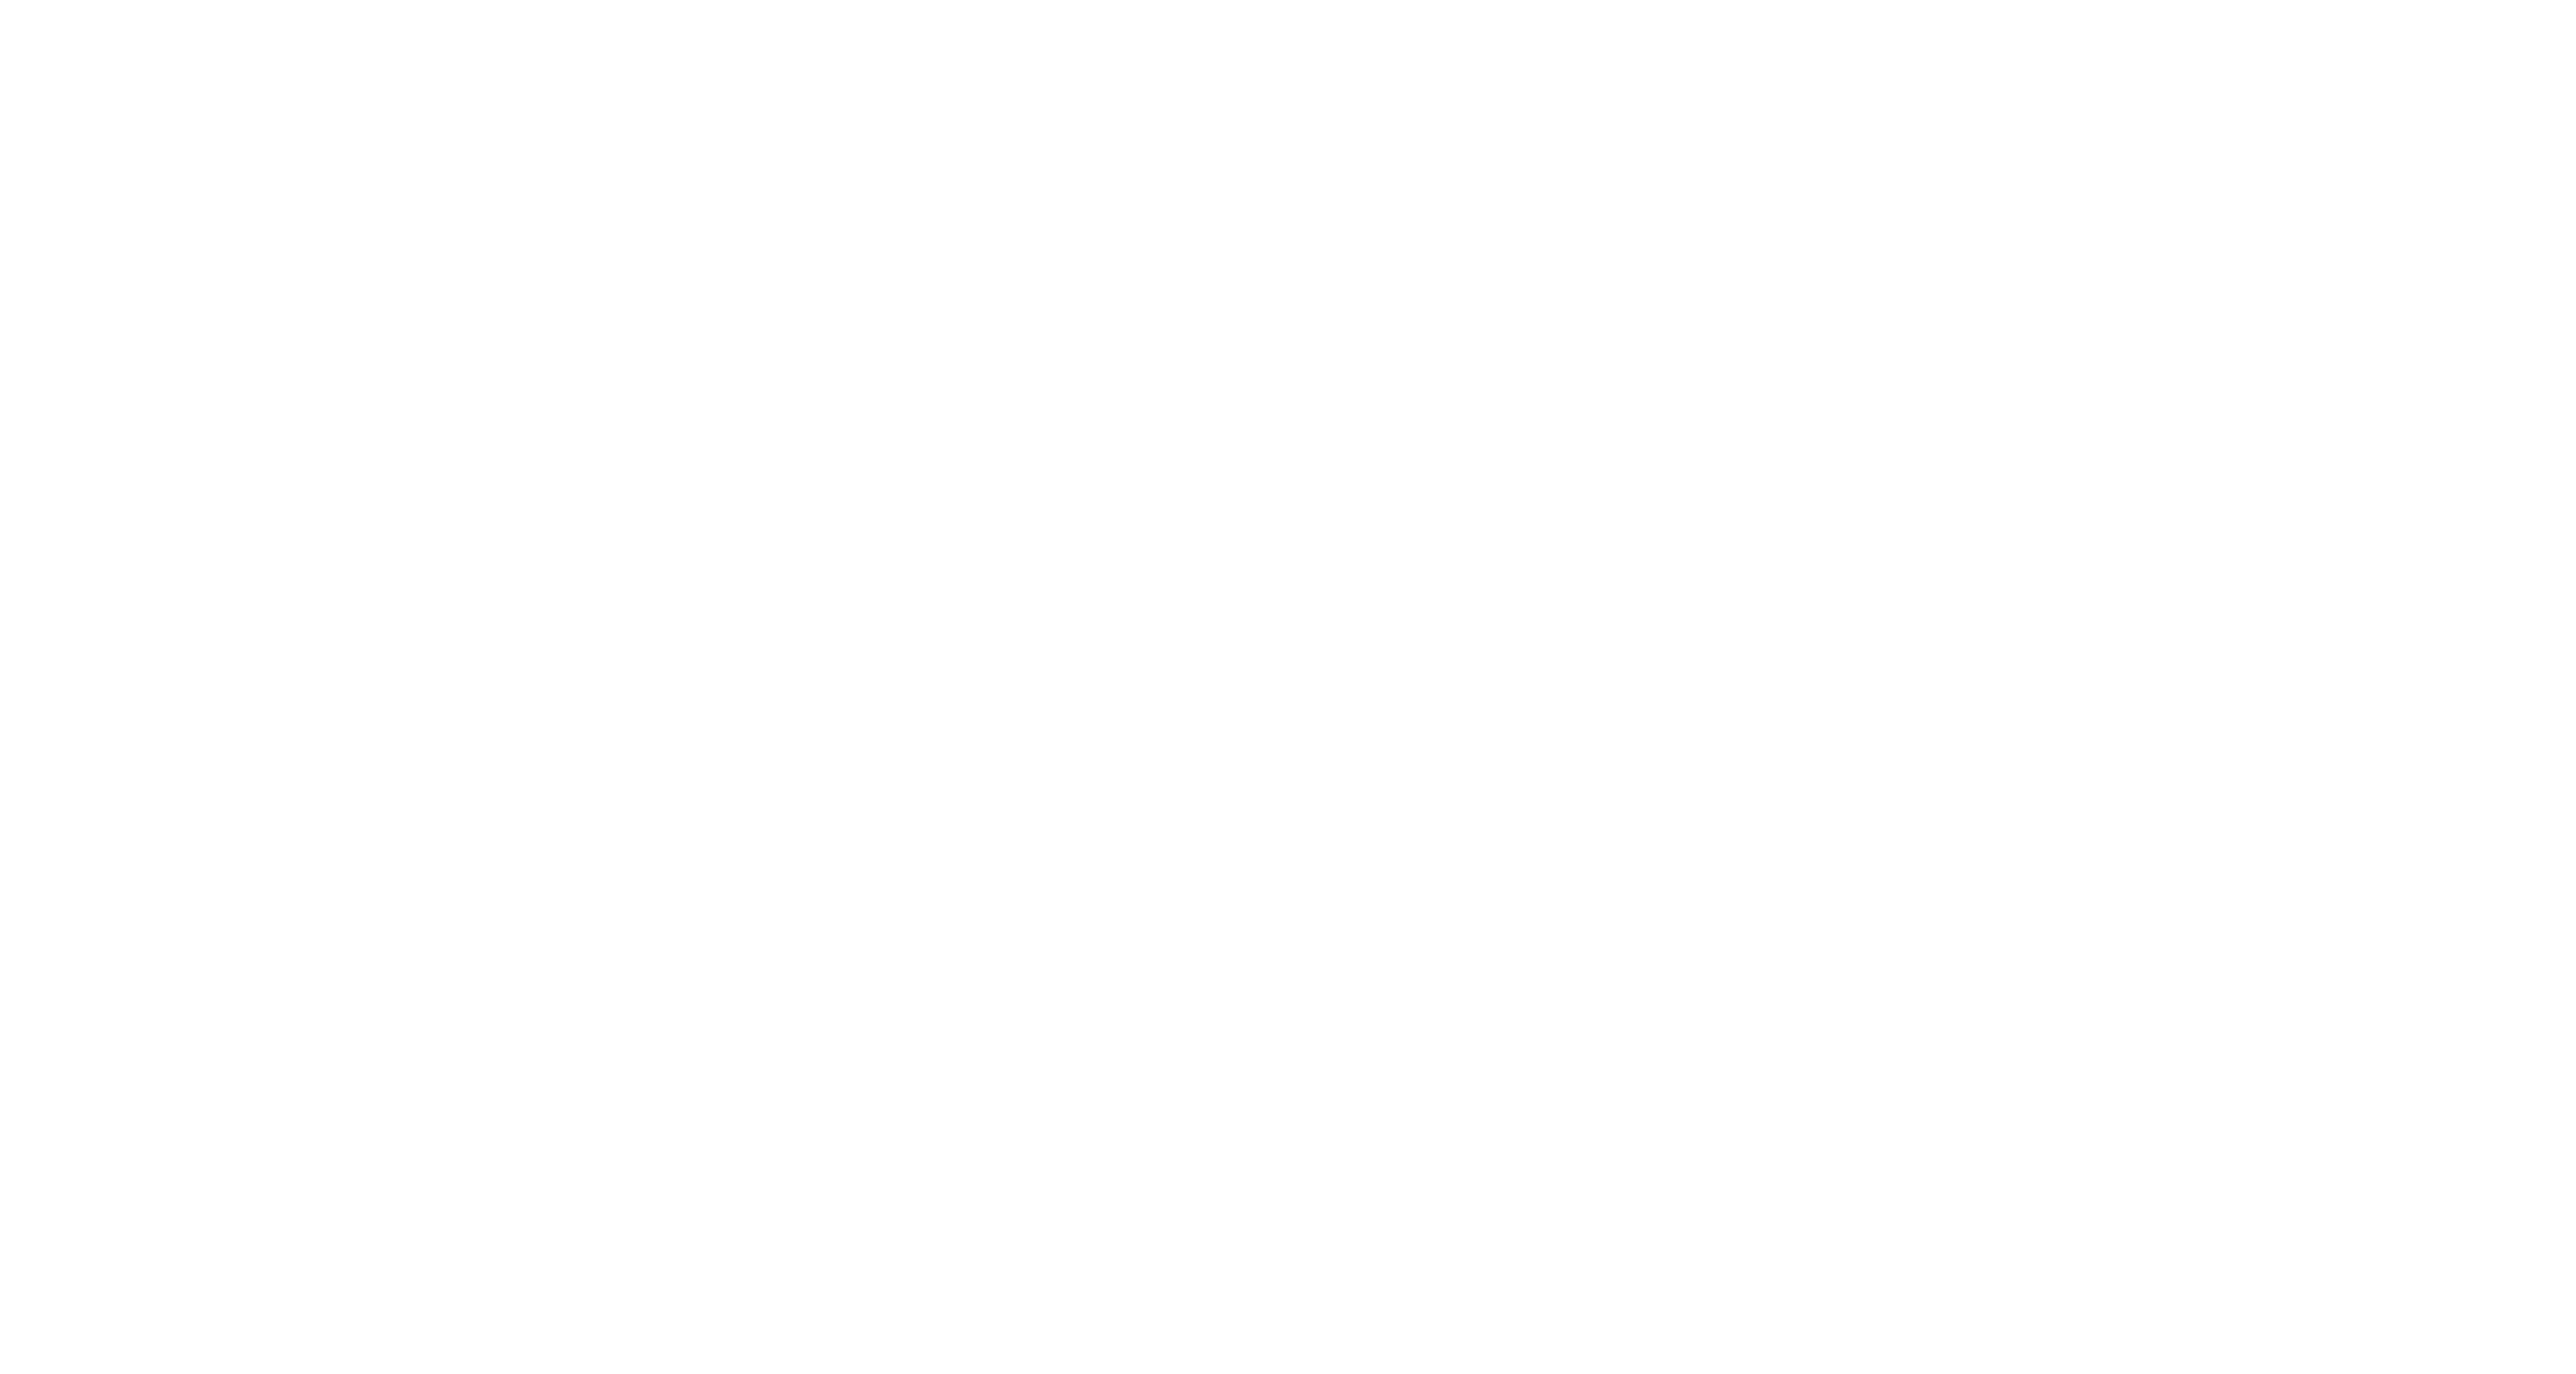

Text(0.5,0.92,'Energy deposit (pion)')

In [27]:
pion_fig = plt.figure(figsize = (15,8))
ay = pion_fig.add_subplot(111, projection='3d')

pc = pion_event.rechit_layer.values
ay.scatter(pz,px,py, s = ps, c = pc)

plt.xlabel("z")
plt.ylabel("x")
ay.set_title("Energy deposit (pion)")

####  Total rechit_energy per event

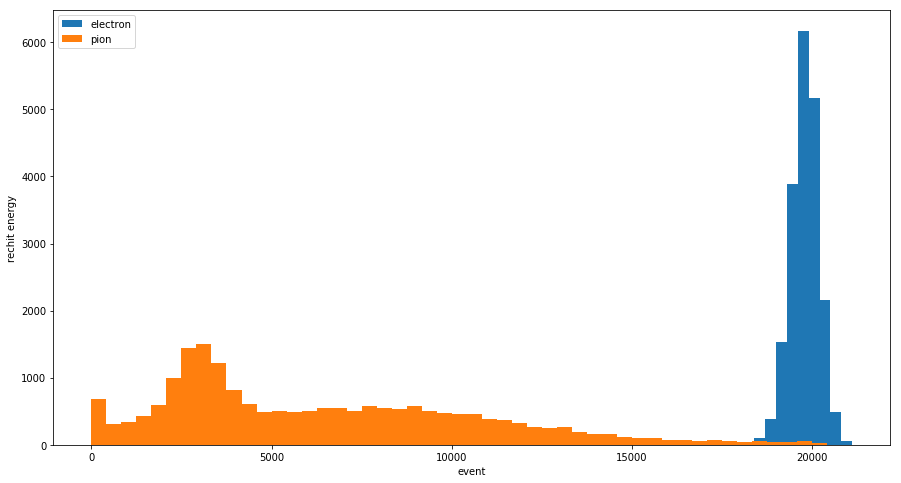

In [28]:
%matplotlib inline
elon_fig = plt.figure(figsize = (15,8))
ee_sum = df_elon.groupby("event").rechit_energy.sum()
pe_sum = df_pion.groupby("event").rechit_energy.sum()

_temp = plt.hist(ee_sum, 50)
_temp = plt.hist(pe_sum, 50)
plt.xlabel("event")
plt.ylabel("rechit energy")

plt.legend(["electron","pion"])

#### Average energy deposite per layer

In [29]:
ee_layers = df_elon.groupby(['event','rechit_layer'])['rechit_energy'].sum().groupby("rechit_layer").mean()
pe_layers = df_pion.groupby(['event','rechit_layer'])['rechit_energy'].sum().groupby("rechit_layer").mean()

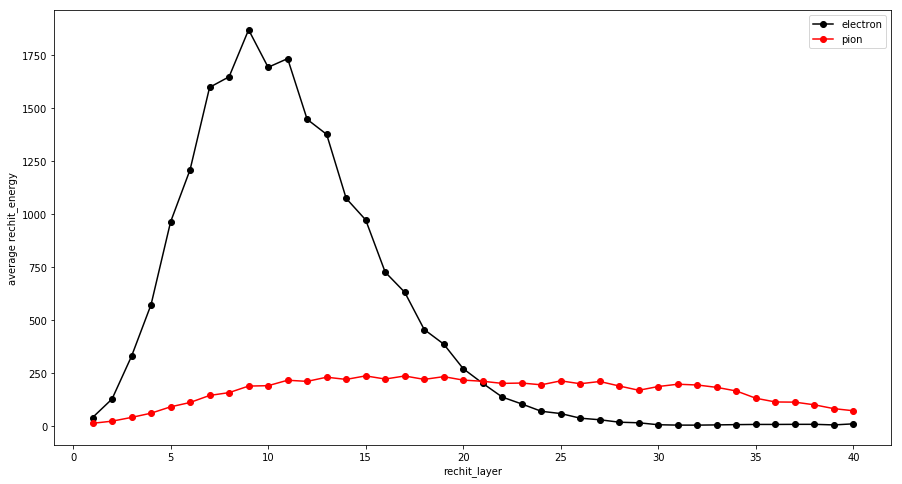

In [30]:
plt.figure(figsize = (15,8))
plt.plot(ee_layers, 'o-',color='k')
plt.plot(pe_layers, 'o-',color='r')
plt.xlabel('rechit_layer')
plt.ylabel('average rechit_energy')

plt.legend(["electron","pion"])

#### Average hits per layer

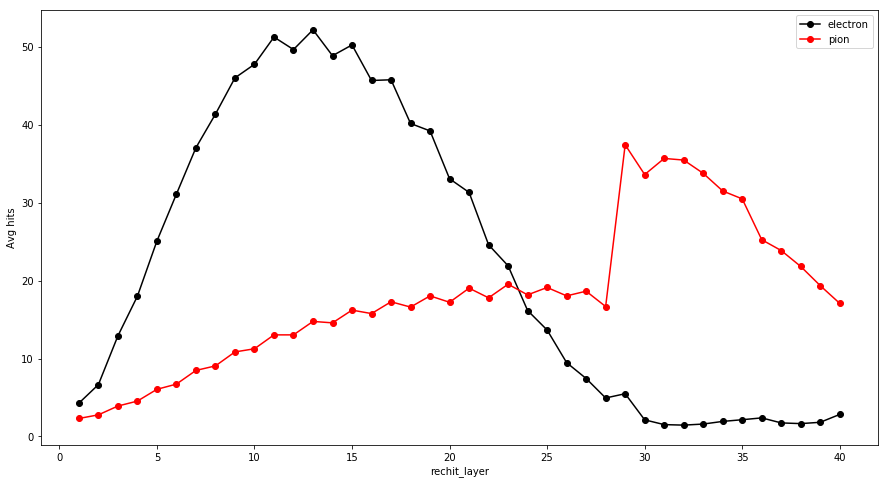

In [31]:
e_hits = df_elon.groupby(['event','rechit_layer']).size().groupby('rechit_layer').mean()
p_hits = df_pion.groupby(['event','rechit_layer']).size().groupby('rechit_layer').mean()

plt.figure(figsize = (15,8))
plt.plot(e_hits,'o-', color='k')
plt.plot(p_hits,'o-', color='r')

plt.xlabel("rechit_layer")
plt.ylabel("Avg hits")

plt.legend(["electron","pion"])

#### Shower in Electromangnatic Chamber (L1 to L28)

In [32]:
EE_elon = df_elon[df_elon.rechit_layer < 29]
EE_pion = df_pion[df_pion.rechit_layer < 29]

#### Average hits per event : EE

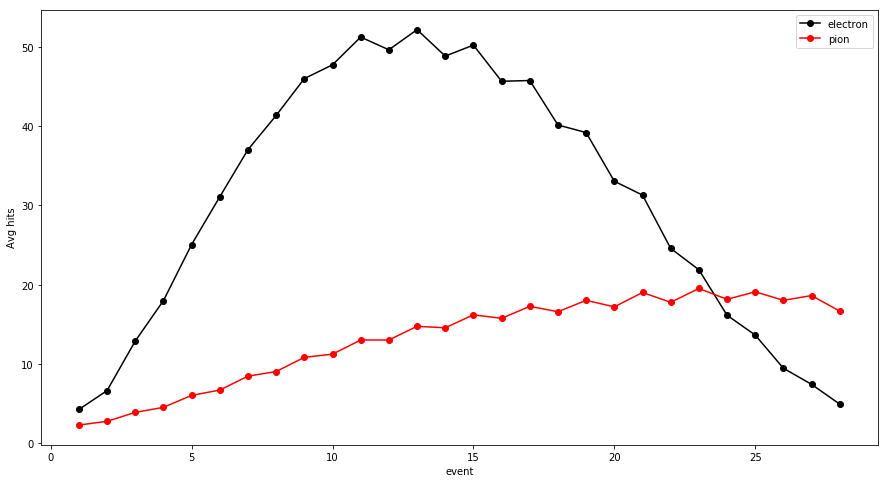

In [33]:
e_hits = EE_elon.groupby(['event','rechit_layer']).size().groupby('rechit_layer').mean()
p_hits = EE_pion.groupby(['event','rechit_layer']).size().groupby('rechit_layer').mean()

plt.figure(figsize = (15,8))
_temp = plt.plot(e_hits,'o-',color='k')
_temp = plt.plot(p_hits,'o-',color='r')
plt.xlabel("event")
plt.ylabel("Avg hits")

plt.legend(["electron","pion"])

In [34]:
_temp = df_elon.groupby(['event','rechit_layer']).rechit_energy.sum().groupby('event').apply(list)

In [35]:
e_energy_layer = df_elon.groupby(['event','rechit_layer']).rechit_energy.sum().groupby('event').apply(list)
p_energy_layer = df_pion.groupby(['event','rechit_layer']).rechit_energy.sum().groupby('event').apply(list)
# e_energy_layer = np.full([len(_temp),40],0)

# for event in range(0,len(_temp)):
#     e_energy_layer[event][:len(_temp[event])] = e
# e_energy_layer

#### Sum of energy deposite in Layer 1 to 20 (E1_E20), Layer 21 to 28 (E21_E28), all events

In [36]:
e_E1_E20, e_E21_E28, = [], []
p_E1_E20, p_E21_E28, = [], []

for layer in e_energy_layer:
    e_E21_E28.append(sum(layer[20:28])) # 20-27th layer
    e_E1_E20.append(sum(layer[:20])) # 0-19th layer
    
for layer in p_energy_layer:
    p_E21_E28.append(sum(layer[20:28])) # 20-27th layer
    p_E1_E20.append(sum(layer[:20])) # 0-19th layer

#### E1_E20, E21_E28 of intial 15 events

Text(0.5,1,'E1_E20 vs E21_E28 : electron')

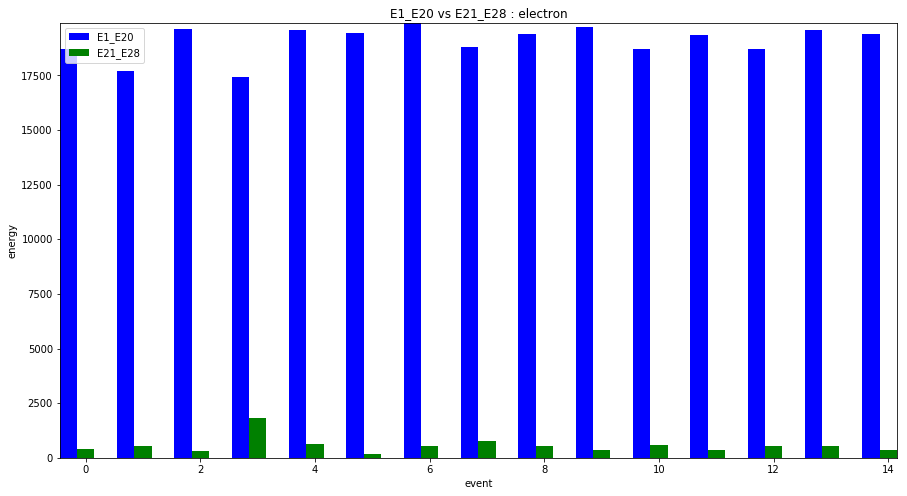

In [37]:
plt.figure(figsize = (15,8))
x = np.arange(15)
ax = plt.subplot(111)
w = 0.3
# plot for intial 10 events
ax.bar(x-w, e_E1_E20[:15], width=w, color='b', align='center')
ax.bar(x, e_E21_E28[:15], width=w, color='g', align='center')
ax.autoscale(tight=True)

plt.xlabel("event")
plt.ylabel("energy")
plt.legend(["E1_E20","E21_E28"])
plt.title("E1_E20 vs E21_E28 : electron")

Text(0.5,1,'E1_E20 vs E21_E28 : pion')

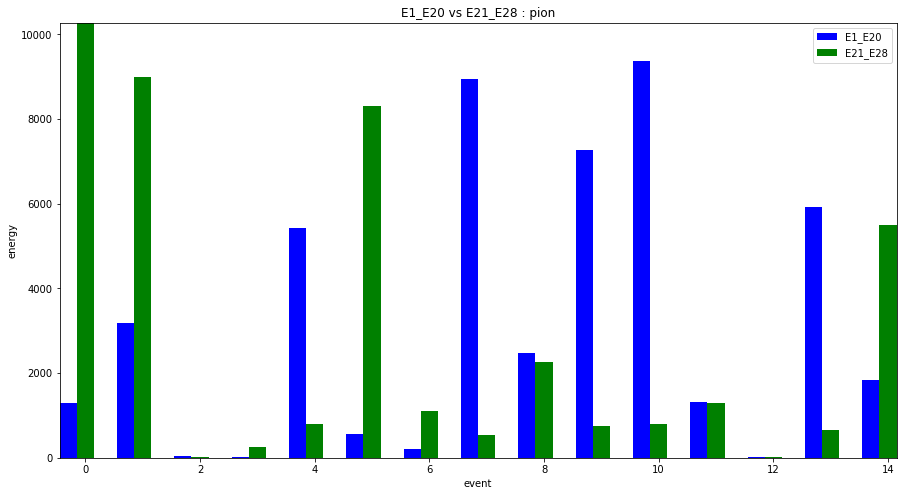

In [38]:
plt.figure(figsize = (15,8))
ax = plt.subplot(111)

ax.bar(x-w, p_E1_E20[:15], width=w, color='b', align='center')
ax.bar(x, p_E21_E28[:15], width=w, color='g', align='center')
ax.autoscale(tight=True)

plt.xlabel("event")
plt.ylabel("energy")
plt.legend(["E1_E20","E21_E28"])
plt.title("E1_E20 vs E21_E28 : pion")

#### E1_E20

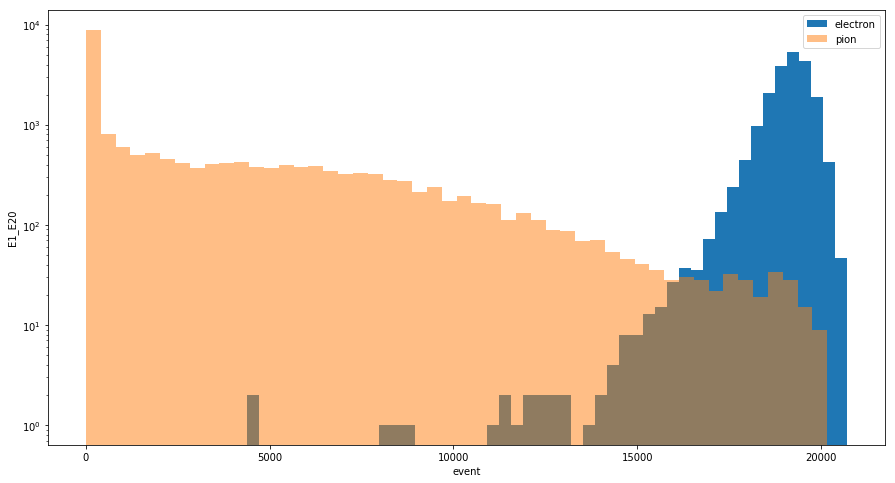

In [39]:
plt.figure(figsize = (15,8))
plt.hist(e_E1_E20,50)
plt.hist(p_E1_E20,50,alpha=0.5)

x = plt.xlabel("event")
y = plt.ylabel("E1_E20")
plt.yscale('log')
plt.legend(["electron","pion"])

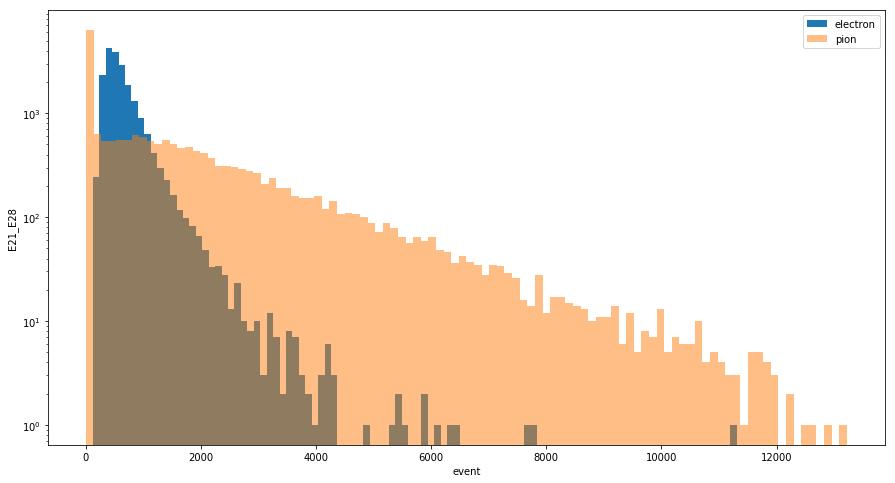

In [40]:
plt.figure(figsize = (15,8))
plt.hist(e_E21_E28,100)
plt.hist(p_E21_E28,100,alpha = 0.5)

x = plt.xlabel("event")
y = plt.ylabel("E21_E28")
plt.yscale('log')
plt.legend(["electron","pion"])

#### ratio of E21_E28 and E1_E20

Text(0.5,1,'E21_E28 / E1_E20 : electron')

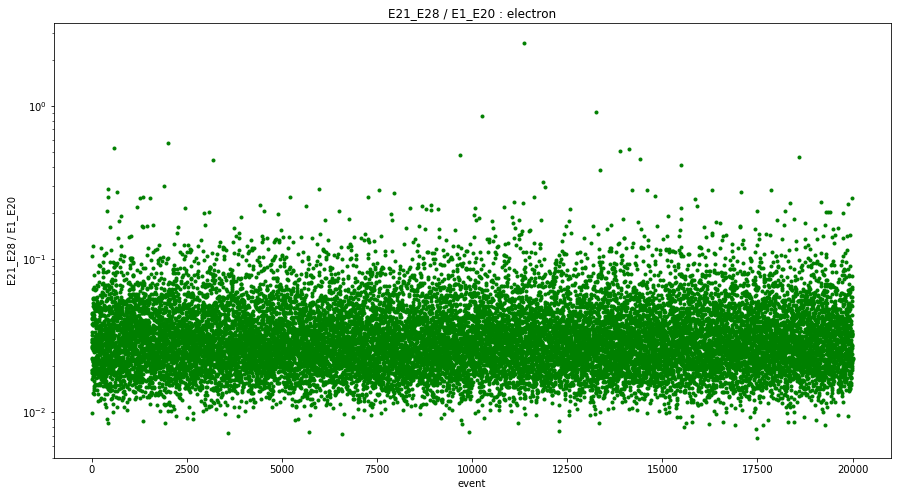

In [41]:
plt.figure(figsize = (15,8))
ratio_e, ratio_p = [], []

for i in range(0,len(e_E1_E20)):
    ratio_e.append(float(e_E21_E28[i]/e_E1_E20[i]))
for i in range(0,len(p_E21_E28)):
    ratio_p.append(float(p_E21_E28[i]/p_E1_E20[i]))
    
plt.plot(ratio_e,'.',color='g')

x = plt.xlabel("event")
y = plt.ylabel("E21_E28 / E1_E20")
plt.yscale('log')
plt.title("E21_E28 / E1_E20 : electron")

Text(0.5,1,'E21_E28 / E1_E20 : pion')

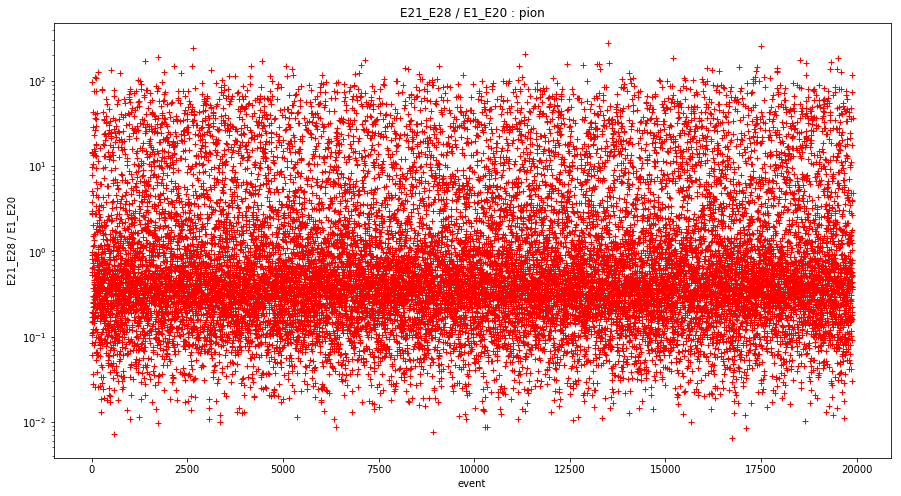

In [42]:
plt.figure(figsize = (15,8))
plt.plot(ratio_p,'+',color='r')

x = plt.xlabel("event")
y = plt.ylabel("E21_E28 / E1_E20")
plt.yscale('log')
plt.title("E21_E28 / E1_E20 : pion")

#### Correlation between electron's E1_E20 and pion's E1_E20

Text(0,0.5,"pion's E1_E20")

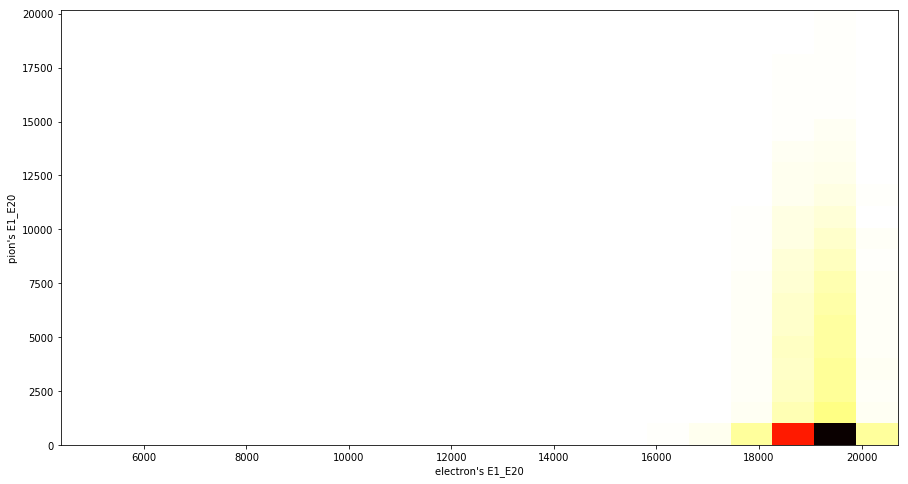

In [47]:
_temp = min(len(e_E1_E20),len(p_E1_E20))
plt.figure(figsize = (15,8))
plt.hist2d(e_E1_E20[:_temp],p_E1_E20[:_temp],20)
plt.xlabel("electron's E1_E20")
plt.ylabel("pion's E1_E20")

#### Correlation between electron's E21_E28 and pion's E21_E28

Text(0,0.5,"pion's E21_E28")

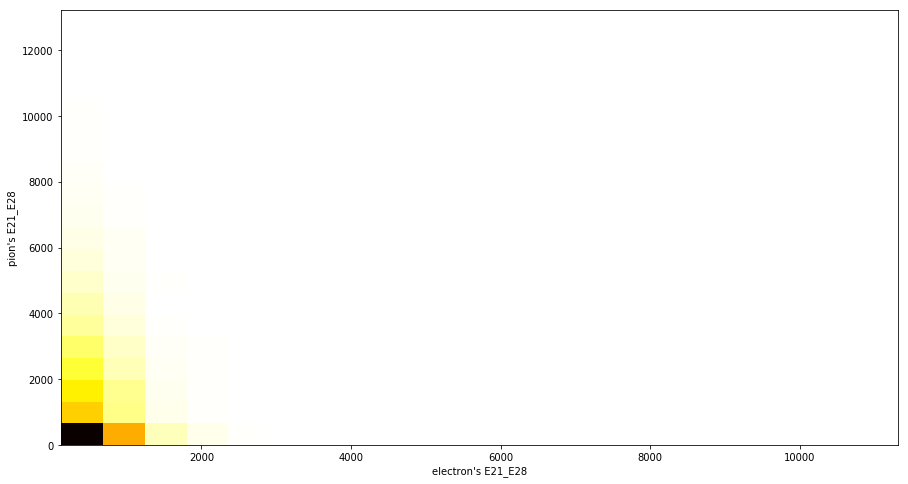

In [48]:
_temp = min(len(e_E21_E28),len(p_E21_E28))
plt.figure(figsize = (15,8))
plt.hist2d(e_E21_E28[:_temp],p_E21_E28[:_temp],20)
plt.xlabel("electron's E1_E20")
plt.ylabel("pion's E1_E20")
plt.xlabel("electron's E21_E28")
plt.ylabel("pion's E21_E28")

#### functions to calculate Barycentre

In [49]:
def get_baryX(event):
    return np.sum(event.rechit_x * event.rechit_energy) / event.rechit_energy.sum()

def get_baryY(event):
    return np.sum(event.rechit_y * event.rechit_energy) / event.rechit_energy.sum()

def get_baryZ(event):
    return np.sum(event.rechit_z * event.rechit_energy) / event.rechit_energy.sum()

### Calculate Barycentres

In [50]:
# electron events barycentre
gb_event = EE_elon.groupby('event')
e_baryX = gb_event.apply(get_baryX)
e_baryY = gb_event.apply(get_baryY)
e_baryZ = gb_event.apply(get_baryZ)

# pion events barycentre
gb_event = EE_pion.groupby('event')
p_baryX = gb_event.apply(get_baryX)
p_baryY = gb_event.apply(get_baryY)
p_baryZ = gb_event.apply(get_baryZ)

#### BaryCentre-X

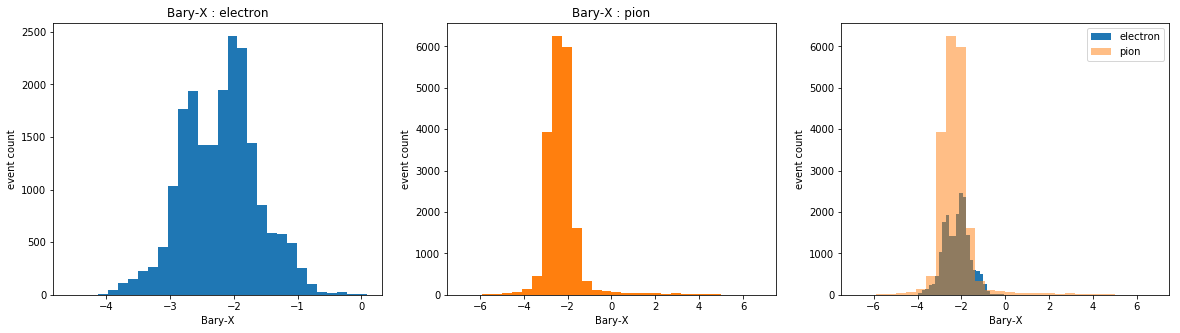

In [51]:
plt.figure(figsize = (20,5))
plt.subplot(1, 3, 1)

plt.hist(e_baryX, 30,color="C0")
plt.xlabel("Bary-X")
plt.ylabel("event count")
plt.title("Bary-X : electron")

plt.subplot(1, 3, 2)
plt.hist(p_baryX, 30,color="C1")
plt.xlabel("Bary-X")
plt.ylabel("event count")
plt.title("Bary-X : pion")

plt.subplot(1, 3, 3)
plt.hist(e_baryX, 30,color="C0")
plt.hist(p_baryX, 30,color="C1",alpha=0.5)
plt.xlabel("Bary-X")
plt.ylabel("event count")


plt.legend(["electron","pion"])

In [59]:
#### correlation bw bary-X (electron) and bary-X (pion)
# _temp = min(len(e_baryX),len(p_baryX)) # There is some problem with pion dataset (event replicas)

# plt.hist2d(e_baryX[:_temp], p_baryX[:_temp], 30)
# plt.xlabel("bary-X (electron)")
# plt.ylabel("bary-X (pion)")

#### BaryCentre-Y

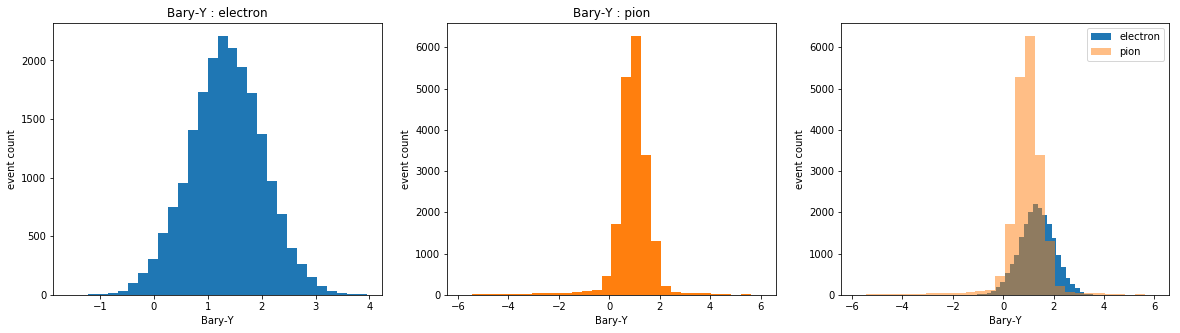

In [52]:
plt.figure(figsize = (20,5))
plt.subplot(1, 3, 1)

plt.hist(e_baryY, 30,color="C0")
plt.xlabel("Bary-Y")
plt.ylabel("event count")
plt.title("Bary-Y : electron")

plt.subplot(1, 3, 2)
plt.hist(p_baryY, 30,color="C1")
plt.xlabel("Bary-Y")
plt.ylabel("event count")
plt.title("Bary-Y : pion")

plt.subplot(1, 3, 3)
plt.hist(e_baryY, 30,color="C0")
plt.hist(p_baryY, 30,color="C1",alpha=0.5)
plt.xlabel("Bary-Y")
plt.ylabel("event count")

plt.legend(["electron","pion"])

In [61]:
#### correlation bw bary-Y (electron) and bary-Y (pion)
# _temp = min(len(e_baryY),len(p_baryY)) # There is some problem with pion dataset (event replicas)

# plt.hist2d(e_baryY[:_temp], p_baryY[:_temp], 30)
# plt.xlabel("bary-Y (electron)")
# plt.ylabel("bary-Y (pion)")

#### BaryCentre-Z

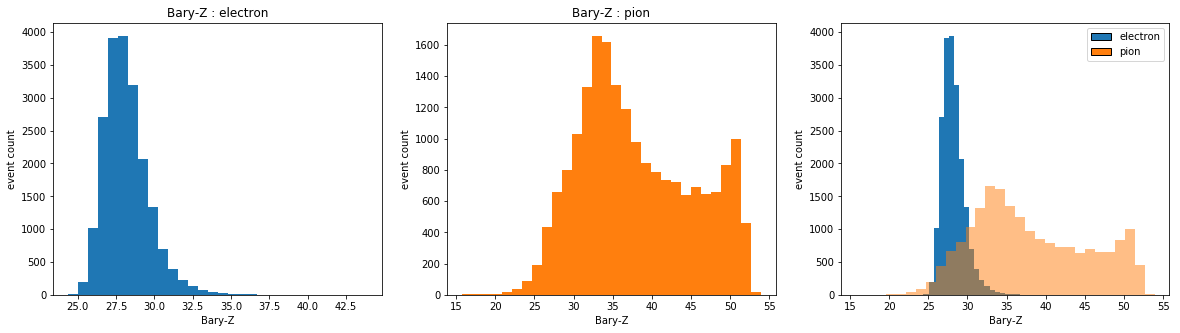

In [53]:
plt.figure(figsize = (20,5))
plt.subplot(1, 3, 1)

plt.hist(e_baryZ, 30,color="C0")
plt.xlabel("Bary-Z")
plt.ylabel("event count")
plt.title("Bary-Z : electron")

plt.subplot(1, 3, 2)
plt.hist(p_baryZ, 30,color="C1")
plt.xlabel("Bary-Z")
plt.ylabel("event count")
plt.title("Bary-Z : pion")

plt.subplot(1, 3, 3)
plt.hist(e_baryZ, 30,color="C0")
plt.hist(p_baryZ, 30,color="C1",alpha=0.5)
plt.xlabel("Bary-Z")
plt.ylabel("event count")

handles = [Rectangle((0,1),1,1,color='C0',ec="k"),
           Rectangle((0,1),1,1,color='C1',ec="k")]

plt.legend(handles,["electron","pion"])

#### correlation bw bary-Z (electron) and bary-Z (pion)

Text(0,0.5,'bary-Z (pion)')

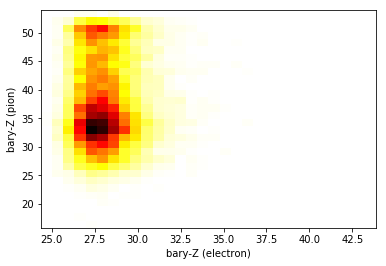

In [54]:
_temp = min(len(e_baryZ),len(p_baryZ)) # There is some problem with pion dataset (event replicas)

plt.hist2d(e_baryZ[:_temp], p_baryZ[:_temp], 30)
plt.xlabel("bary-Z (electron)")
plt.ylabel("bary-Z (pion)")

In [64]:
#### correlation bw bary-X (electron) and bary-Y (electron)
# _temp = min(len(e_baryX),len(e_baryY)) # There is some problem with pion dataset (event replicas)

# plt.hist2d(e_baryX[:_temp], p_baryY[:_temp], 30)
# plt.xlabel("bary-X (electron)")
# plt.ylabel("bary-Y (electron)")

#### Barycentre-X Barycentre-X and Barycentre-Z

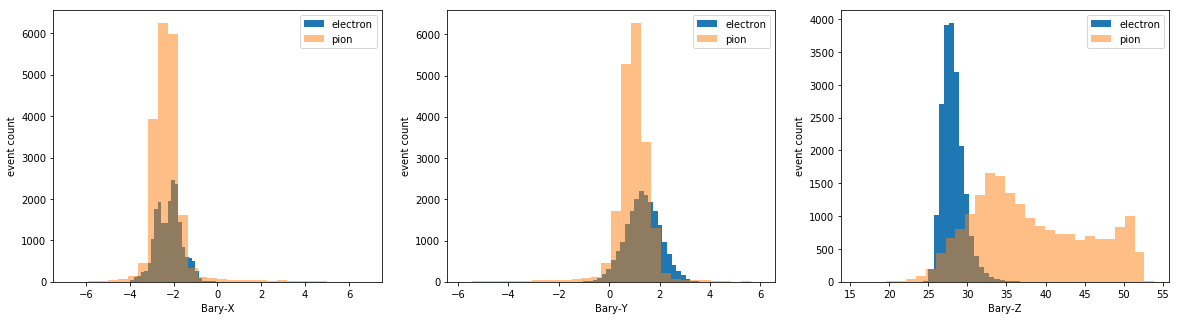

In [56]:
plt.figure(figsize = (20,5))

plt.subplot(1, 3, 1)
plt.hist(e_baryX, 30,color="C0")
plt.hist(p_baryX, 30,color="C1",alpha=0.5)
plt.xlabel("Bary-X")
plt.ylabel("event count")
_temp = plt.legend(["electron","pion"])

plt.subplot(1, 3, 2)
plt.hist(e_baryY, 30,color="C0")
plt.hist(p_baryY, 30,color="C1",alpha=0.5)
plt.xlabel("Bary-Y")
plt.ylabel("event count")
_temp = plt.legend(["electron","pion"])

plt.subplot(1, 3, 3)
plt.hist(e_baryZ, 30,color="C0")
plt.hist(p_baryZ, 30,color="C1",alpha=0.5)
plt.xlabel("Bary-Z")
plt.ylabel("event count")

_temp = plt.legend(["electron","pion"])

#### correlation bw ["hits","energy","hit_energy_ration","E1_E20","E21_E28","layer_ratio","baryZ"] for electron

#### correlation bw ["hits","energy","hit_energy_ratio","E1_E20","E21_E28","layer_ratio","baryZ"] for pion

In [86]:
# variables = ["hits","energy","hit_energy_ration","E1_E20","E21_E28","layer_ratio","baryZ"]

# dsf = pd.DataFrame(columns = variables) # empty dataframe

# dsf.hits = p_hits
# dsf.energy = p_energy
# dsf.hit_energy_ration = p_hits / p_energy
# dsf.E1_E20 = p_E1_E20
# dsf.E21_E28 = p_E21_E28
# dsf.layer_ratio = ratio_p
# dsf.baryZ = p_baryZ

# corr_matrix = dsf.corr()
# f, ax = plt.subplots(figsize=(10, 8))
# _temp = sns.heatmap(corr_matrix, mask=np.zeros_like(corr_matrix, dtype=np.bool),
#                     cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, ax=ax)

# ax.set_title("pion")

### An event with EE

#### dx, dy and dz [ dx = rechit_x - baryX ]

In [60]:
event_id = 1
dx = pd.DataFrame(columns=['dxi']) # empty dataframe with column dxi

elon_event = df_elon[df_elon.index == event_id] # electron
pion_event = df_pion[df_pion.index == event_id] # pion

e_data = elon_event[['rechit_layer','rechit_energy',
                     'rechit_x','rechit_y','rechit_z']].reset_index(drop=True)
p_data = pion_event[['rechit_layer','rechit_energy',
                     'rechit_x','rechit_y','rechit_z']].reset_index(drop=True)


e_dxdydz = pd.DataFrame(e_data,columns=['rechit_layer','dx','dy','dz']) # empty dataframe with dx','dy','dz'
e_dxdydz.dx = (e_data.rechit_x - e_baryX.reset_index(drop=True)[event_id-1])
e_dxdydz.dy = (e_data.rechit_y - e_baryY.reset_index(drop=True)[event_id-1])
e_dxdydz.dz = (e_data.rechit_z - e_baryZ.reset_index(drop=True)[event_id-1])

p_dxdydz = pd.DataFrame(p_data,columns=['rechit_layer','dx','dy','dz'])
p_dxdydz.dx = (p_data.rechit_x - p_baryX.reset_index(drop=True)[event_id-1])
p_dxdydz.dy = (p_data.rechit_y - p_baryY.reset_index(drop=True)[event_id-1])
p_dxdydz.dz = (p_data.rechit_z - p_baryZ.reset_index(drop=True)[event_id-1])

#### dx for each EE layers

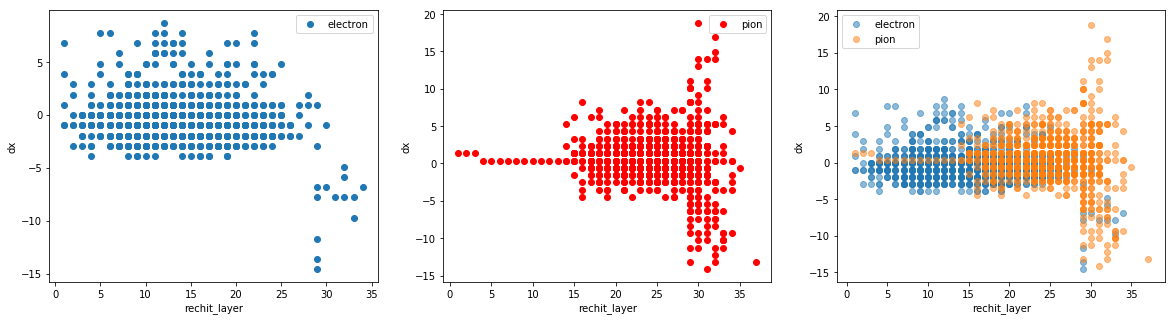

In [68]:
plt.figure(figsize = (20,5))

plt.subplot(1, 3, 1)
plt.scatter(e_dxdydz['rechit_layer'],e_dxdydz['dx'])
plt.xlabel("rechit_layer")
plt.ylabel("dx")
plt.legend(["electron","pion"])

plt.subplot(1, 3, 2)
plt.scatter(p_dxdydz['rechit_layer'],p_dxdydz['dx'],color='r')
plt.xlabel("rechit_layer")
plt.ylabel("dx")
plt.legend(["pion"])

plt.subplot(1, 3, 3)
plt.scatter(e_dxdydz['rechit_layer'],e_dxdydz['dx'],alpha=0.5)
plt.scatter(p_dxdydz['rechit_layer'],p_dxdydz['dx'],alpha=0.5)
plt.xlabel("rechit_layer")
plt.ylabel("dx")
plt.legend(["electron","pion"])

#### dy for each EE layers

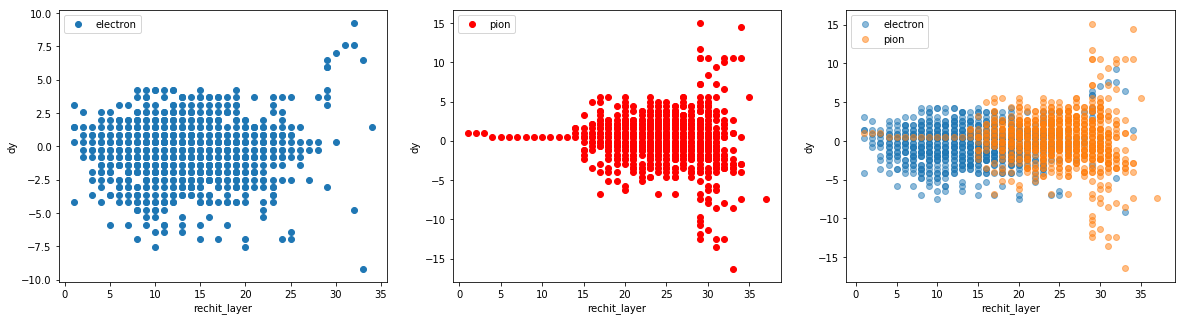

In [69]:
plt.figure(figsize = (20,5))

plt.subplot(1, 3, 1)
plt.scatter(e_dxdydz['rechit_layer'],e_dxdydz['dy'])
plt.xlabel("rechit_layer")
plt.ylabel("dy")
plt.legend(["electron"])

plt.subplot(1, 3, 2)
plt.scatter(p_dxdydz['rechit_layer'],p_dxdydz['dy'],color='r')
plt.xlabel("rechit_layer")
plt.ylabel("dy")
plt.legend(["pion"])

plt.subplot(1, 3, 3)
plt.scatter(e_dxdydz['rechit_layer'],e_dxdydz['dy'],alpha=0.5)
plt.scatter(p_dxdydz['rechit_layer'],p_dxdydz['dy'],alpha=0.5)
plt.xlabel("rechit_layer")
plt.ylabel("dy")

_temp = plt.legend(["electron","pion"])

#### dz for each EE layers

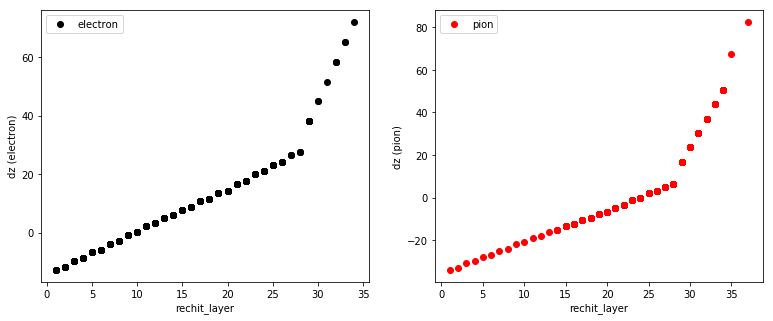

In [70]:
plt.figure(figsize = (20,5))

plt.subplot(1, 3, 1)
plt.scatter(e_dxdydz['rechit_layer'],e_dxdydz['dz'],color='k')
plt.xlabel("rechit_layer")
plt.ylabel("dz (electron)")
plt.legend(["electron"])

plt.subplot(1, 3, 2)
plt.scatter(p_dxdydz['rechit_layer'],p_dxdydz['dz'],color='r')
plt.xlabel("rechit_layer")
plt.ylabel("dz (pion)")
plt.legend(["pion"])

In [71]:
e_hypot_dx_dy = pd.DataFrame(columns=['rechit_layer','sqrt_dx_dy'])
e_hypot_dx_dy.rechit_layer = e_dxdydz['rechit_layer']
e_hypot_dx_dy.sqrt_dx_dy = np.sqrt(np.square(e_dxdydz['dx'])+np.square(e_dxdydz['dy']))
e_sqrt_dx_dy = e_hypot_dx_dy.groupby('rechit_layer').sqrt_dx_dy.mean()

p_hypot_dx_dy = pd.DataFrame(columns=['rechit_layer','sqrt_dx_dy'])
p_hypot_dx_dy.rechit_layer = p_dxdydz['rechit_layer']
p_hypot_dx_dy.sqrt_dx_dy = np.sqrt(np.square(p_dxdydz['dx'])+np.square(p_dxdydz['dy']))
p_sqrt_dx_dy = p_hypot_dx_dy.groupby('rechit_layer').sqrt_dx_dy.mean()

#### dR = sqrt(dx^2 + dy^2) for each EE layer

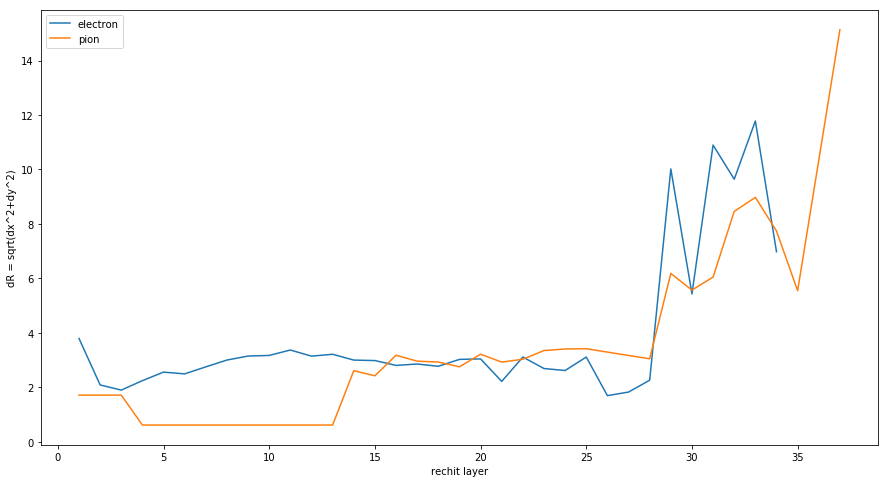

In [79]:
plt.figure(figsize = (15,8))
plt.plot(e_sqrt_dx_dy)

plt.xlabel("rechit layer")
plt.ylabel("dR = sqrt(dx^2+dy^2)")

plt.plot(p_sqrt_dx_dy)

plt.xlabel("rechit layer")

_temp = plt.legend(["electron","pion"])

In [80]:
# release unnecessary memory
e_hypot_dx_dy, p_hypot_dx_dy = None, None

In [80]:
temp_df = pd.DataFrame(columns=['rechit_layer','rechit_energy','sum_energy_rechit_z'])

temp_df.rechit_layer = elon_event.rechit_layer
temp_df.rechit_energy = elon_event.rechit_energy
temp_df.sum_energy_rechit_z = elon_event.rechit_energy * elon_event.rechit_z

#### Energy Fraction: layer(i) rechit_energy / total rechit_energy

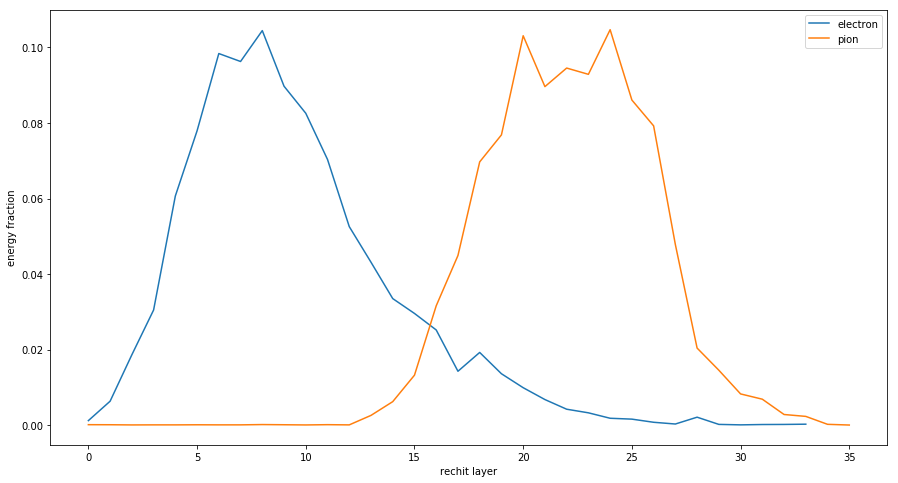

In [81]:
plt.figure(figsize = (15,8))
e_energy_fraction = elon_event.groupby('rechit_layer').rechit_energy.sum().reset_index(drop=True) # sum of rechit_energy per layer
e_energy_fraction = e_energy_fraction / elon_event.rechit_energy.sum() # total rechit energy


p_energy_fraction = pion_event.groupby('rechit_layer').rechit_energy.sum().reset_index(drop=True) # sum of rechit_energy per layer
p_energy_fraction = p_energy_fraction / pion_event.rechit_energy.sum()


plt.plot(e_energy_fraction)
plt.plot(p_energy_fraction)

plt.xlabel("rechit layer")
plt.ylabel("energy fraction")

_temp = plt.legend(["electron","pion"])